# Infection régionale française avec le nouveau coronavirus (SRAS-CoV-2), COVID-19

Sante Publique France fournit les taux quotidiens [confirmés d'infection](https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde) au niveau régional. Toutefois, ces taux sont fournis sous la forme d'un tableau statique unique sans historique.

Je les ai compilés en une série chronologique et je vais essayer de les tenir à jour pendant la pandémie. N'hésitez pas à les utiliser comme vous le souhaitez. Code publié sous licence BSD-3 et tout le reste comme CC-By.

Shapefiles de [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/contours-geographiques-des-nouvelles-regions-metropole/).

Exigences: Pandas, Matplotlib, GeoPandas, GeoPlot

In [2]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

In [3]:
data_file = "data/covid-19-data.csv"
df = pd.read_csv(data_file)
# Filtrer par date limite
latest_date = df["Date"].max()
df[df["Date"] == latest_date].head(14)

,Région,Date,Cas-confirmés
198,Auvergne-Rhône-Alpes,2020-03-19,1014
199,Bourgogne-Franche-Comté,2020-03-19,696
200,Bretagne,2020-03-19,297
201,Centre-Val de Loire,2020-03-19,157
202,Corse,2020-03-19,162
203,Grand Est,2020-03-19,2643
204,Hauts-de-France,2020-03-19,700
205,Ile-de-France,2020-03-19,3384
206,Normandie,2020-03-19,241
207,Nouvelle-Aquitaine,2020-03-19,280


## Carte des points

In [4]:
# Ouvrez le fichier "shapefile" appelé "contours-geographiques-des-nouvelles-regions-metropole.shp" 
# et notez que - si vous faites cela chez vous ordinateur, vous devrez charger le fichier à partir 
# de l'endroit où vous l'avez enregistré
shape_data = gpd.GeoDataFrame.from_file("data/contours-geographiques-des-nouvelles-regions-metropole.shp")
regions = {"Grand-Est": "Grand Est",
           "Bourgogne-Franche-ComtÃ©": "Bourgogne-Franche-Comté", 
           "Auvergne-RhÃ´ne-Alpes": "Auvergne-Rhône-Alpes", 
           "Provence-Alpes-CÃ´te d'Azur": "Provence-Alpes-Côte d’Azur", 
           "Nouvelle Aquitaine": "Nouvelle-Aquitaine"
          }
shape_data["region"] = shape_data["region"].replace(regions)
boundaries = pd.merge(shape_data, df[df["Date"] == latest_date], 
                      how="outer", 
                      left_on="region", 
                      right_on="Région", 
                      indicator=True)
boundaries = boundaries[boundaries["_merge"]=="both"]

In [5]:
centroidseries = shape_data['geometry'].centroid
centroids = shape_data.copy()
centroids["geometry"] = centroidseries

centroids = pd.merge(centroids, df[df["Date"] == latest_date], 
                     how="outer", 
                     left_on="region", 
                     right_on="Région", 
                     indicator=True)
centroids = centroids[centroids["_merge"]=="both"]

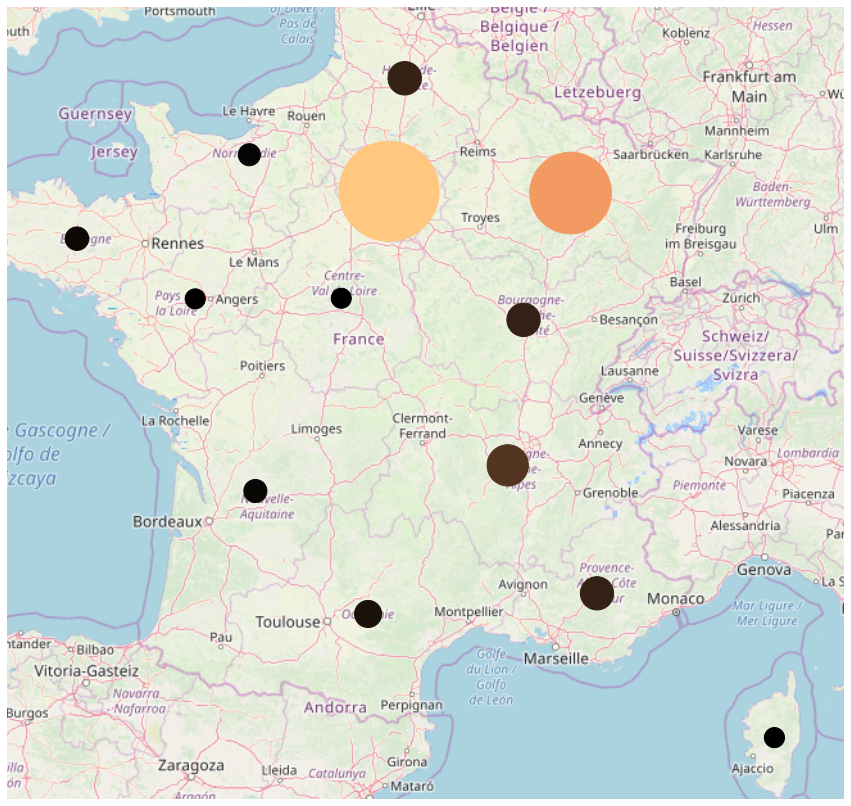

In [6]:
ax = gplt.webmap(boundaries, 
                 projection=gcrs.WebMercator(), 
                 figsize=(15,15))
gplt.pointplot(centroids,
               projection=gcrs.AlbersEqualArea(),
               scale="Cas-confirmés", limits=(20, 100),
               hue="Cas-confirmés", cmap="copper",
               ax=ax)

## Choroplèthe

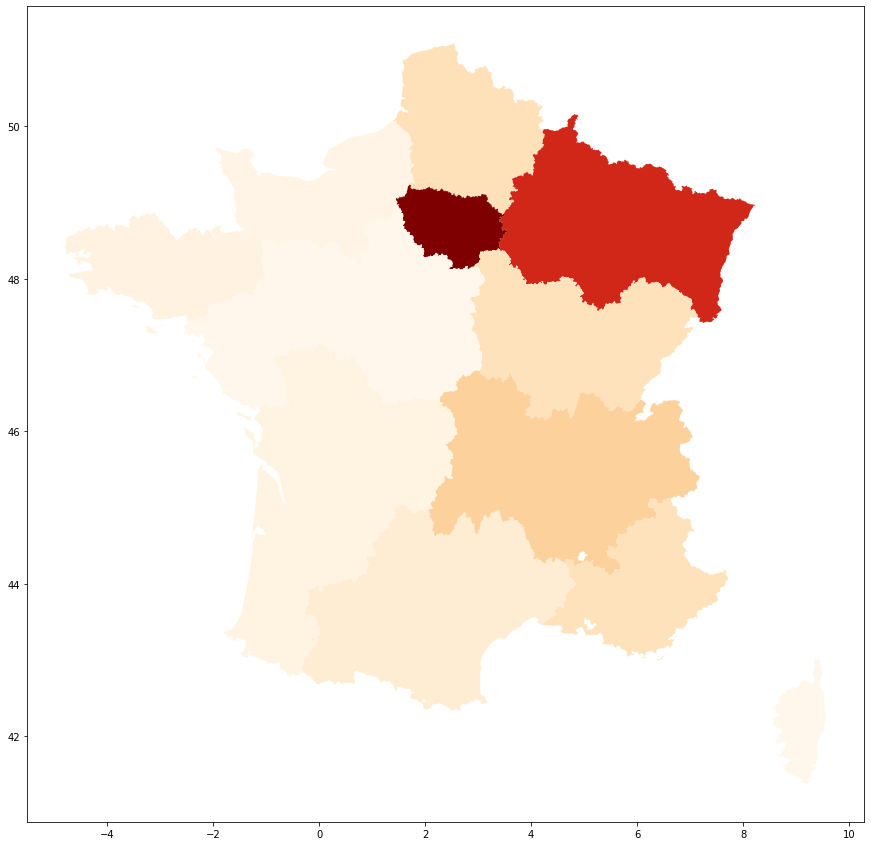

In [7]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(15,15))
boundaries.plot(ax=ax, column="Cas-confirmés", cmap="OrRd")

## Graphiques linéaires

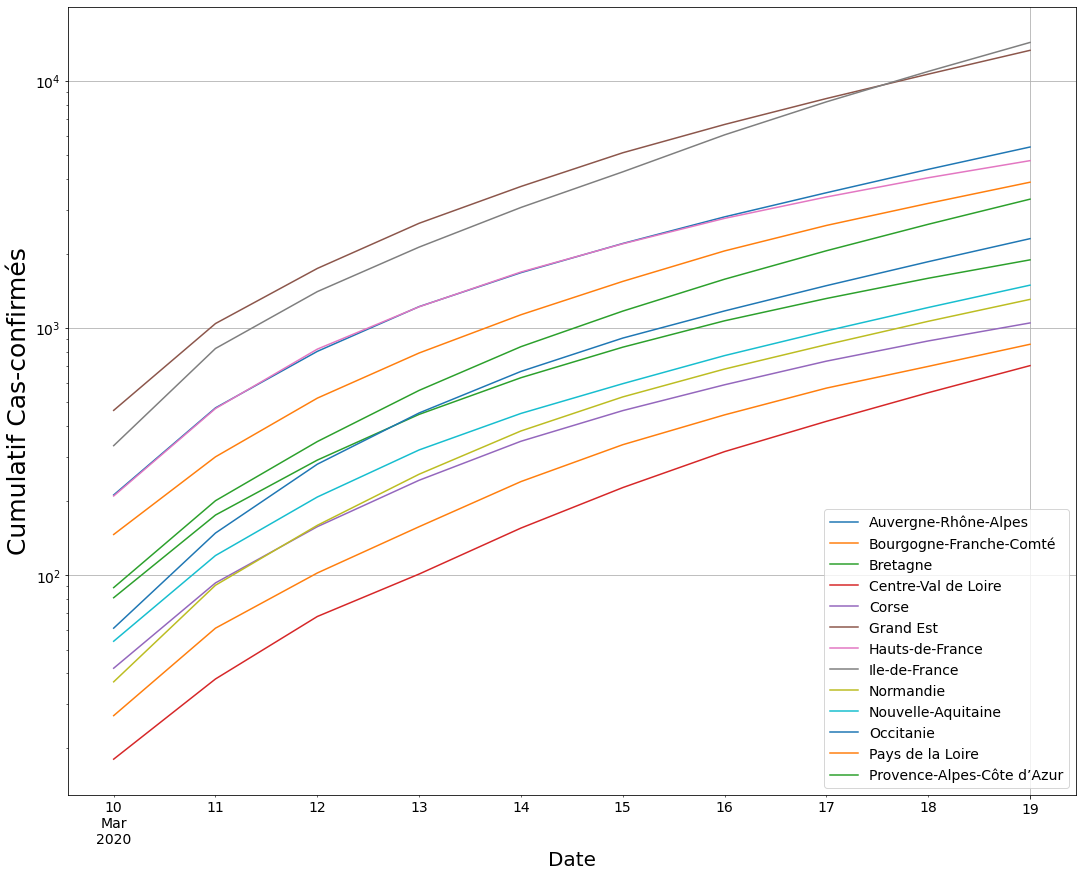

In [8]:
df["Cumulatif-cas-confirmés"] = df.groupby("Région")["Cas-confirmés"].cumsum()
df["Date"] = pd.to_datetime(df.Date)
drawing = pd.pivot_table(df[df["Région"].isin(boundaries["Région"])],
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.set_ylabel("Cumulatif Cas-confirmés", size=25)
ax.set_xlabel("Date", size=20)
drawing.plot(grid=True, logy=True, fontsize=14, ax=ax)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, fontsize=14, title_fontsize="large")

C:\Users\Turukawa\Anaconda3\envs\datascience\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


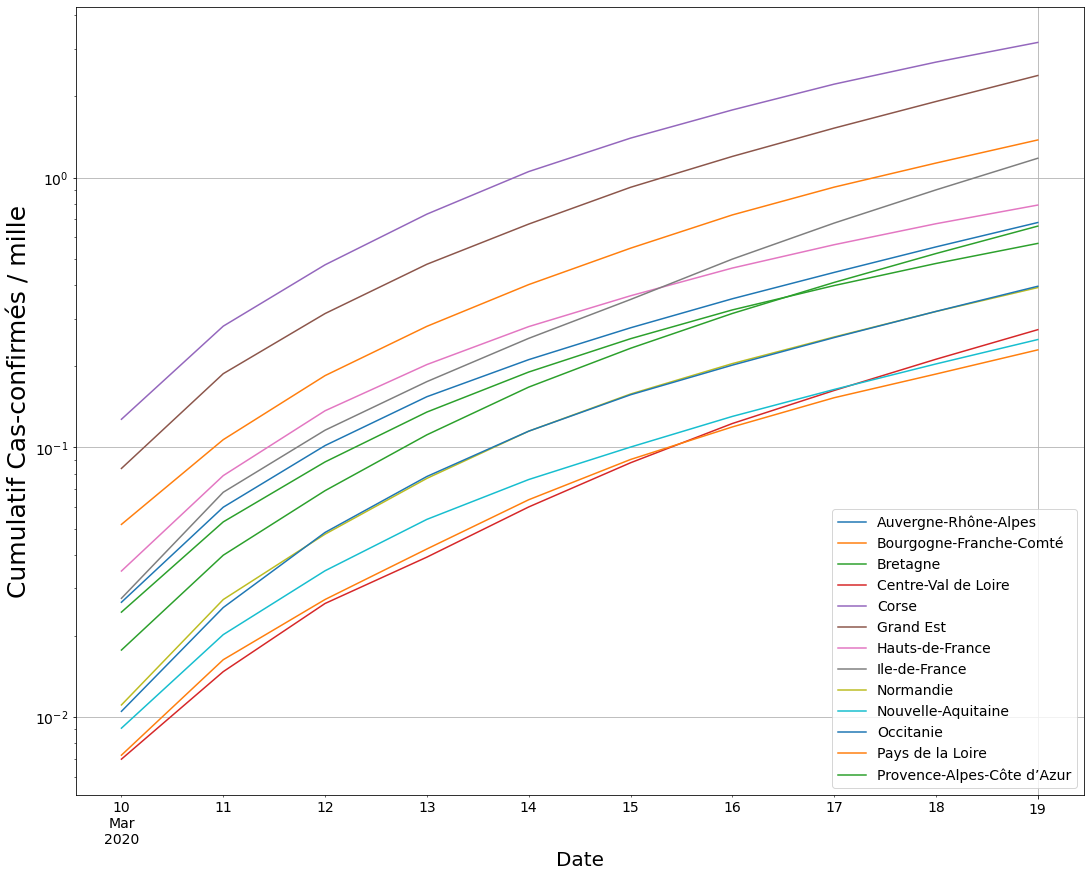

In [34]:
population_file = "data/France-population.csv"
pf = pd.read_csv(population_file)
chunks = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    d = pf[pf["Région"]==name]["Population"].values[0] / 1000
    region.loc[:, "Cumulatif-cas-confirmés"] = region.apply(lambda x: x["Cumulatif-cas-confirmés"]/d, 
                                                            axis=1)
    chunks.append(region)
pf = pd.concat(chunks)
drawing = pd.pivot_table(pf,
                         values="Cumulatif-cas-confirmés",
                         index=["Date"],
                         columns=["Région"])
fig, ax = plt.subplots(figsize=(20,15))
fig.subplots_adjust(bottom=0.15, left=0.2)
ax.set_ylabel("Cumulatif Cas-confirmés / mille", size=25)
ax.set_xlabel("Date", size=20)
drawing.plot(grid=True, logy=True, fontsize=14, ax=ax)
h, l = ax.get_legend_handles_labels()
ax.legend(h, l, fontsize=14, title_fontsize="large")

## Région infection doublant le temps

Référence : [Lisa Charlotte Rost, DataWrapper](https://blog.datawrapper.de/weekly-chart-coronavirus-doublingtimes/)

In [77]:
import math
from datetime import datetime, timedelta
from tabulate import tabulate

def doubling_time(x, y, z):
    """
    x est le temps qui s'est écoulé depuis que vous avez commencé à mesurer. 
        Par exemple, si le nombre de cas est passé de 500 le jour 0 à 1000 le jour 2, x est égal à 2.
    y est le nombre de cas au jour x, par exemple 1000 au jour 2.
    z est le nombre de cas au jour 0, par exemple 500.
    """
    return (x*math.log(2))/(math.log(y/z))

N = 4
headers = ["Région",
           F"t. dbler ({N}j)",
           F"{N}j avant",
           "chger",
           F"n. cas ({N}j)",
           F"{N}j avant",
           "chger"
          ]
rows = []
for name, region in df[df["Région"].isin(boundaries["Région"])].groupby(["Région"]):
    date_latest = region["Date"].max()
    date_N = date_latest - timedelta(days=N)
    date_2N = date_last - timedelta(days=N)
    # Lates
    yN = region[region["Date"] == date_latest].iloc[0]["Cumulatif-cas-confirmés"]
    zN = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_N = doubling_time(x=N, y=yN, z=zN)
    # les nouveaux cas confirmés au cours des cinq derniers jours
    case_N = yN - zN
    # Précédent
    y2N = region[region["Date"] == date_N].iloc[0]["Cumulatif-cas-confirmés"]
    z2N = region[region["Date"] == date_2N].iloc[0]["Cumulatif-cas-confirmés"]
    # le doublement du temps au cours des cinq derniers jours
    double_2N = doubling_time(x=N, y=y2N, z=z2N)
    # les cas confirmés dans les cinq jours précédents
    case_2N = y2N - z2N
    # Changement dans le temps de doublement
    if double_N == double_2N: double_change = "~"
    if double_N > double_2N:
        if double_N / double_2N >= 0.5:
            double_change = "▲▲"
        else:
            double_change = "▲"
    if double_2N > double_N:
        if double_2N / double_N >= 0.5:
            double_change = "▼▼"
        else:
            double_change = "▼"
    # Changement dans les cas confirmés
    if case_N == case_2N: case_change = "~"
    if case_N > case_2N:
        if case_N / case_2N >= 0.5:
            case_change = "▲▲"
        else:
            case_change = "▲"
    if case_2N > case_N:
        if case_2N / case_N >= 0.5:
            case_change = "▼▼"
        else:
            case_change = "▼"
    rows.append([
        name,
        "{0:.2f}".format(double_N), "{0:.2f}".format(double_2N), double_change,
        case_N, case_2N, case_change,
    ])

In [75]:
print(tabulate(rows,
               headers=headers, 
               tablefmt="fancy_grid"))

╒════════════════════════════╤═════════════════╤════════════╤═════════╤═══════════════╤════════════╤═════════╕
│ Région                     │   t. dbler (4j) │   4j avant │ chger   │   n. cas (4j) │   4j avant │ chger   │
╞════════════════════════════╪═════════════════╪════════════╪═════════╪═══════════════╪════════════╪═════════╡
│ Auvergne-Rhône-Alpes       │            3.08 │       1.81 │ ▲▲      │          3200 │       1722 │ ▲▲      │
├────────────────────────────┼─────────────────┼────────────┼─────────┼───────────────┼────────────┼─────────┤
│ Bourgogne-Franche-Comté    │            3    │       1.7  │ ▲▲      │          2345 │       1242 │ ▲▲      │
├────────────────────────────┼─────────────────┼────────────┼─────────┼───────────────┼────────────┼─────────┤
│ Bretagne                   │            3.41 │       1.77 │ ▲▲      │          1050 │        661 │ ▲▲      │
├────────────────────────────┼─────────────────┼────────────┼─────────┼───────────────┼────────────┼─────────┤
│